# Computer Vision - Face Detection


In [36]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import pathlib
import cv2
import PIL

from tensorflow.keras.layers import Input, Concatenate, UpSampling2D, Conv2D, Reshape, Activation, BatchNormalization, SpatialDropout2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications.mobilenet import MobileNet

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [37]:
print(tf.__version__)

2.5.0


In [38]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


## Import data

In [39]:
print(os.listdir("drive/My Drive/Projects/Advanced CNN/"))

['Part 1Test Data - Prediction Image.jpeg', 'Part 1- Train data - images.npy']


In [40]:
#Load images with numpy
images = np.load('drive/My Drive/Projects/Advanced CNN/Part 1- Train data - images.npy', 
                 allow_pickle=True)
print("The shape of the data is: {}".format(images.shape))

The shape of the data is: (409, 2)


In [41]:
print("Type of the dataset is {}".format(type(images)))
# print(images.shape)
# print(images)
print("There are {} images in the dataset.".format(len(images)))

Type of the dataset is <class 'numpy.ndarray'>
There are 409 images in the dataset.


## Analyse images and masks

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063}, {'x': 0.1723076923076923, 'y': 0.45345345345345345}], 'imageWidth': 650, 'imageHeight': 333}, {'label': ['Face'], 'notes': '', 'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913}, {'x': 0.6584615384615384, 'y': 0.46846846846846846}], 'imageWidth': 650, 'imageHeight': 333}]


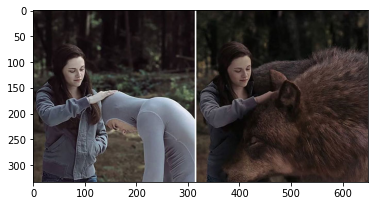

In [42]:
print(images[0][1])
plt.imshow(images[0][0]);

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.7053087757313109, 'y': 0.23260437375745527}, {'x': 0.7692307692307693, 'y': 0.36182902584493043}], 'imageWidth': 1280, 'imageHeight': 697}]


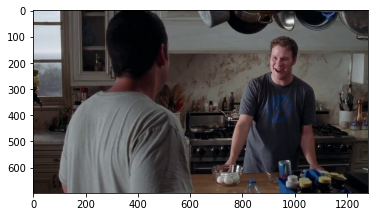

In [43]:
print(images[1][1])
plt.imshow(images[1][0]);

In [44]:
# Image dimensions
img_width = 224
img_height = 224
alpha = 1

## Create features (images) and labels (mask)

In [45]:
masks = np.zeros((int(images.shape[0]), img_height, img_width))
X_trn = np.zeros((int(images.shape[0]), img_height, img_width, 3))
for index in range(images.shape[0]):
    img = images[index][0]
    img = cv2.resize(img, dsize=(img_height, img_width), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_trn[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in images[index][1]:
        x1 = int(i["points"][0]['x'] * img_width)
        x2 = int(i["points"][1]['x'] * img_width)
        y1 = int(i["points"][0]['y'] * img_height)
        y2 = int(i["points"][1]['y'] * img_height)
        masks[index][y1:y2, x1:x2] = 1

In [46]:
# !pip install git+https://github.com/qubvel/segmentation_models

In [47]:
print(X_trn.shape)
print(masks.shape)

(409, 224, 224, 3)
(409, 224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


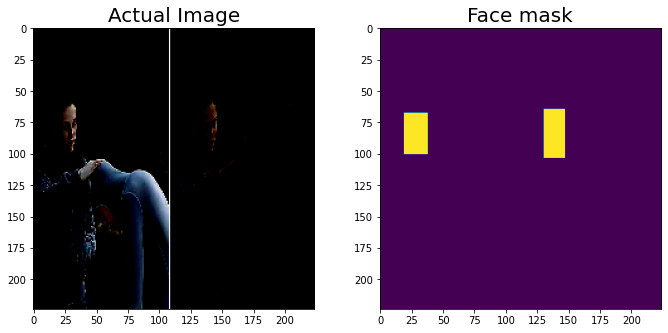

In [48]:
#Check the images and mask
plt.figure(figsize=(30,30))

plt.subplot(5,5,1)
plt.title("Actual Image",fontsize=20)
plt.imshow(X_trn[0])

plt.subplot(5,5,1+1)
plt.title("Face mask",fontsize=20)
plt.imshow(masks[0]);

## Building mask detection model

In [49]:
cell_height = 224
cell_width = 224

batch_size = 1
threads = 1

In [50]:
model = MobileNet(input_shape=(img_height, img_width, 3), include_top=False, alpha=alpha, weights="imagenet")
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [51]:
def conv_block_simple(prevlayer, filters, prefix, strides=(1, 1)):
    conv = Conv2D(filters, (3, 3), padding = 'same', kernel_initializer = 'he_normal', strides = strides, name = prefix + '_conv')(prevlayer)
    conv = BatchNormalization(name = prefix + 'BatchNormalization')(conv)
    conv = Activation('relu', name = prefix + 'ActivationLayer')(conv)
    return conv

In [52]:
def create_model(trainable=True):
    model = MobileNet(input_shape=(img_height, img_width, 3), include_top=False, alpha=alpha, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable

    block1 = model.get_layer("conv_pw_5_relu").output
    block2 = model.get_layer("conv_pw_11_relu").output
    block3 = model.get_layer("conv_pw_13_relu").output

    block4 = model.get_layer("conv_pw_3_relu").output
    block5 = model.get_layer("conv_pw_1_relu").output

    x = Concatenate()([UpSampling2D()(block3), block2])
    x = conv_block_simple(x, 256, 'conv_6_1')
    x = conv_block_simple(x, 256, 'conv_6_2')


    x = Concatenate()([UpSampling2D()(x), block1])
    x = conv_block_simple(x, 256, 'conv_7_1')
    x = conv_block_simple(x, 256, 'conv_7_2')

    x = Concatenate()([UpSampling2D()(x), block4])
    x = conv_block_simple(x, 192, 'conv_8_1')
    x = conv_block_simple(x, 128, 'conv_8_2')

    x = Concatenate()([UpSampling2D()(x), block5])
    x = conv_block_simple(x, 96, 'conv_9_1')
    x = conv_block_simple(x, 64, 'conv_9_2')

    x = Concatenate()([UpSampling2D()(x), model.input])
    x = conv_block_simple(x, 48, 'conv_10_1')
    x = conv_block_simple(x, 32, 'conv_10_2')
    x = SpatialDropout2D(0.2)(x)

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((cell_height, cell_width))(x)

    return Model(inputs=model.input, outputs=x)

In [53]:
# Create model
model = create_model()

# Print summary
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_7[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 32) 0           conv1_bn[0][0]                   
____________________________________________________________________________________________

In [54]:
# Dice co-effiecient
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

In [55]:
# Loss
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

In [56]:
opt = Adam(learning_rate = 1e-4, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)
# model.summary()
model.compile(loss=loss, optimizer=opt, metrics=[dice_coefficient])

In [57]:
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

In [59]:
X_train, X_valid, y_train, y_valid = train_test_split(X_trn, masks, test_size = 0.3, random_state = 7, shuffle = False)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((286, 224, 224, 3), (123, 224, 224, 3), (286, 224, 224), (123, 224, 224))

In [61]:
model.fit(X_train, y_train, epochs = 10, batch_size=1, callbacks=[checkpoint, reduce_lr, stop], validation_data = (X_valid, y_valid))

Epoch 1/10
286/286 [==============================] - 540s 2s/step - loss: 1.2981 - dice_coefficient: 0.4433 - val_loss: 1.2537 - val_dice_coefficient: 0.4245

Epoch 00001: loss improved from inf to 1.29810, saving model to model-1.30.h5
Epoch 2/10
286/286 [==============================] - 539s 2s/step - loss: 0.9704 - dice_coefficient: 0.5368 - val_loss: 0.9942 - val_dice_coefficient: 0.5082

Epoch 00002: loss improved from 1.29810 to 0.97040, saving model to model-0.97.h5
Epoch 3/10
286/286 [==============================] - 538s 2s/step - loss: 0.8028 - dice_coefficient: 0.5987 - val_loss: 0.9895 - val_dice_coefficient: 0.5285

Epoch 00003: loss improved from 0.97040 to 0.80281, saving model to model-0.80.h5
Epoch 4/10
286/286 [==============================] - 539s 2s/step - loss: 0.6627 - dice_coefficient: 0.6572 - val_loss: 0.9746 - val_dice_coefficient: 0.5306

Epoch 00004: loss improved from 0.80281 to 0.66272, saving model to model-0.66.h5
Epoch 5/10
286/286 [================

In [62]:
model.evaluate(X_valid, y_valid, verbose = 1)

4/4 [==============================] - 50s 12s/step - loss: 0.8041 - dice_coefficient: 0.6151


[0.8040926456451416, 0.6151232123374939]

Dice co-efficient measures the similarity between two sets of data. Dice co-efffient value should be closer to 1 to achieve better predictions. We were able to achieve 0.84 dice co-efficient with loss of 0.28 in 10 epochs on train data which is pretty good.

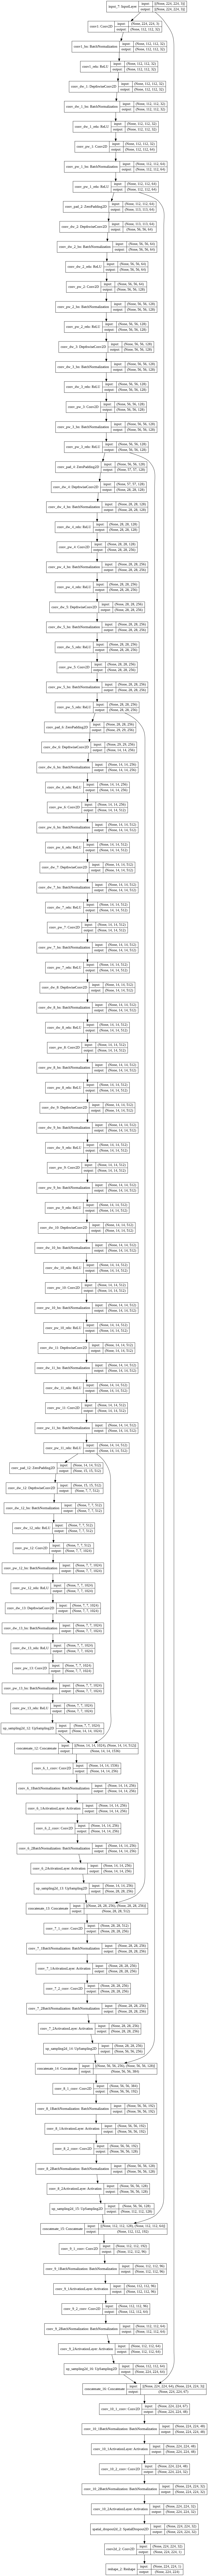

In [63]:
# Checking the model network
from keras.utils.vis_utils import plot_model
plot_model(model,to_file='model.png',show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image(retina=True, filename='model.png')

## Predicting the face mask for the test image

In [64]:
pred_folder='drive/My Drive/Projects/Advanced CNN'
pred = cv2.imread(pred_folder+'/Part 1Test Data - Prediction Image.jpeg')

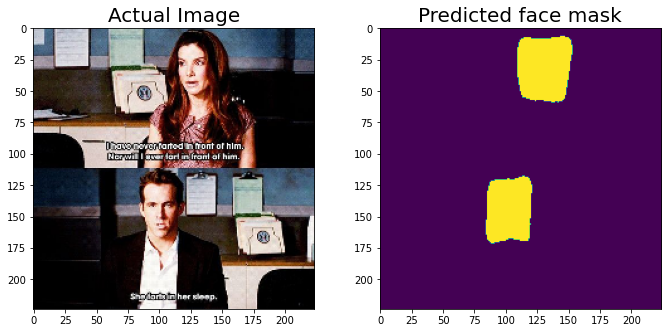

In [70]:
plt.figure(figsize=(30,30))

plt.subplot(5,5,1)
image = cv2.resize(pred, dsize=(img_height, img_width), interpolation=cv2.INTER_CUBIC)
ax = plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));

image_0 = cv2.resize(pred, dsize=(img_height, img_width), interpolation=cv2.INTER_CUBIC)
image_0 = cv2.cvtColor(image_0, cv2.COLOR_BGR2RGB)
plt.title("Actual Image",fontsize=20)
plt.imshow(image_0)

feat_scaled = preprocess_input(np.array(image, dtype=np.float32))
pred_mask = cv2.resize(1.0*(model.predict(x=np.array([feat_scaled]))[0] > 0.2), (img_width,img_height))
plt.subplot(5,5,1+1)
plt.title("Predicted face mask",fontsize=20)
plt.imshow(pred_mask, alpha=1);

We can observe that the face mask detection of our model is almost accurate for a new image.